In [1]:
import numpy as np
import scipy.linalg
import sklearn.metrics as skmetrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
import optuna
import warnings
warnings.filterwarnings("ignore")

In [2]:
file_name = "2.txt"

In [3]:
file = open(file_name)
n, dtrain = int(file.readline().strip()), int(file.readline().strip())
print(n, dtrain)
train = np.array([[int(a) for a in file.readline().strip().split()] for i in range(dtrain)])
dtest = int(file.readline().strip())
test = np.array([[int(a) for a in file.readline().strip().split()] for i in range(dtest)])
dtest

82 1283


256

In [31]:
scaler = MinMaxScaler()
train_F = scaler.fit_transform(np.array([[(train[i][j]) for j in range(n)] for i in range(dtrain)]))
test_F = scaler.transform(np.array([[(test[i][j]) for j in range(n)] for i in range(dtest)]))
train_y = scaler.fit_transform(np.array([[train[i][n]] for i in range(dtrain)]))
test_y = scaler.transform(np.array([[test[i][n]] for i in range(dtest)]))

In [36]:
def calc_mnk_svd(n, F, y, tau = 0):
    v, d, ut = scipy.linalg.svd(F, full_matrices=False)
    vt = np.transpose(v)
    teta = np.zeros((1, n))
    for i in range(n):
        a1 =   (vt[i] @ y)[0]
        #print(a1)
        a = ut[i]
        teta = teta + a * (a1 * d[i] / (d[i]  * d[i] + tau))
    return np.transpose(teta)

In [40]:
def squeeze_column(x):
    return np.squeeze(np.asarray(x))
def mse(y, y_pred):
    return ((y - y_pred)**2).mean(axis=0)
def nrmse(y, y_pred):
    return (((y - y_pred)**2).mean(axis=0) ** 0.5) / (max(y) - min(y))
def smape(y, y_pred):
    return 100/len(y) * np.sum(np.abs(y_pred - y) / (np.abs(y) + np.abs(y_pred)))
def objective_svd_mse(trial):
    x = trial.suggest_float('x', -9, 5)
    return mse(squeeze_column(test_y), squeeze_column(test_F @ calc_mnk_svd(n, train_F, train_y, tau=math.exp(x))))
def objective_svd_smape(trial):
    x = trial.suggest_float('x', -9, 5)
    return smape(squeeze_column(test_y), squeeze_column(test_F @ calc_mnk_svd(n, train_F, train_y, tau=math.exp(x))))


In [52]:

optuna.logging.set_verbosity(optuna.logging.ERROR)

study_mse = optuna.create_study()
study_mse.optimize(objective_svd_mse, n_trials=200)
reg_coef_mnk_mse = math.exp(study_mse.best_params['x'])
print(study_mse.best_params['x'])
study_smape = optuna.create_study()
study_smape.optimize(objective_svd_smape, n_trials=100)
print(study_smape.best_params['x'])
reg_coef_mnk_smape = math.exp(study_smape.best_params['x'])

print("mse best tau parameter:", reg_coef_mnk_mse)
print("smape best tau parameter:", reg_coef_mnk_smape)

-7.853429031854175
-7.984137515148755
mse best tau parameter: 0.00038841778512391847
smape best tau parameter: 0.00034082632708765256


In [144]:
x1 = [-9 + i / 10 for i in range(0, 90)]
x2 = [-9 + i / 10 for i in range(0, 90)]
y1 = [nrmse(squeeze_column(test_y), squeeze_column(test_F @ calc_mnk_svd(n, train_F, train_y, tau=math.exp(i)))) for i in x1]
y2 = [smape(squeeze_column(test_y), squeeze_column(test_F @ calc_mnk_svd(n, train_F, train_y, tau=math.exp(i)))) for i in x2]

In [145]:
w_mnk = calc_mnk_svd(n, train_F, train_y, tau=reg_coef_mnk_smape)

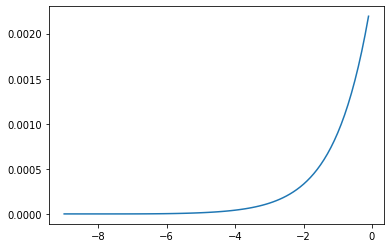

In [146]:
plt.plot(x1, y1)

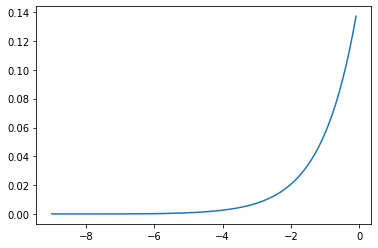

In [147]:
plt.plot(x2, y2)

In [126]:
def gradient_descent(n, F, y, tau, mu, w_start, l_fun, l_grad):
    perm = np.random.permutation(len(y))
    ls = []
    it = 0
    for i in perm:
        #print( w_start)
        w_start = w_start * (1 - mu * tau) - mu * l_grad(F[i], y[i][0], w_start)
        ls.append(l_fun(squeeze_column(y), squeeze_column(F @ w_start)))
        i += 1
        if i == 2000:
            break
    return (w_start, ls)

In [127]:
def mse_grad(x, y, w):
    return (-2 * (y - w @ (x)) * x)

def objective_grad_mse(trial):
    mu = trial.suggest_float('mu', -9, 0)
    tau = trial.suggest_float('tau', -9, 0)
    w_start = np.array([np.random.uniform(-1 / (2 * n), 1 / (2 * n)) for i in range(n)])
    w, ls = gradient_descent(n, train_F, train_y, math.exp(tau), math.exp(mu), w_start, mse, mse_grad)
    return mse(squeeze_column(test_y), squeeze_column(test_F @ w))

study_mse = optuna.create_study()
study_mse.optimize(objective_grad_mse, n_trials=100)
print(study_mse.best_params)

{'mu': -3.6668492134748156, 'tau': -6.074615828853492}


In [128]:
tau_mse_grad = math.exp(study_mse.best_params['tau'])
mu_mse_grad = math.exp(study_mse.best_params['mu'])

In [129]:
w_start = np.array([np.random.uniform(-1 / (2 * n), 1 / (2 * n)) for i in range(n)])
w_grad_mse, ls = gradient_descent(n, train_F, train_y, tau_mse_grad, mu_mse_grad, w_start, mse, mse_grad)

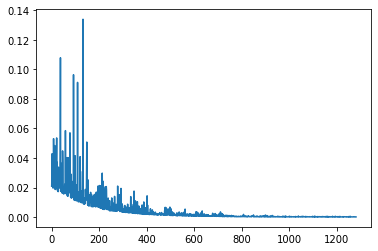

In [130]:
plt.plot([i for i in range(len(ls))], ls)

In [149]:
def smape_grad(x, y, w):
    wx = w @ x
    #print(abs(y))
    return 100 * x * np.sign(wx - y) * (abs(y) + np.sign(wx) * y) / (np.sign(wx) * wx + abs(y)) ** 2 
    if wx - y > 0 and wx > 0:
        return -100* x * ((y + abs(y)) / ((wx + abs(y))**2))
    if wx - y <= 0 and wx > 0:
        return -100* x*(-(y + abs(y))/ ((wx + abs(y))**2))
    if wx - y > 0 and wx <= 0:
        return -100 * x*((abs(y) - y)/ ((abs(y) - wx)**2))
    return 100* x*((abs(y) - y)/ ((abs(y) - wx)**2))

def objective_grad_smape(trial):
    mu = trial.suggest_float('mu', -13, 0)
    tau = trial.suggest_float('tau', -13, 0)
    #w_start = np.array([np.random.uniform(-1 / (2 * n), 1 / (2 * n)) for i in range(n)])
    w, ls = gradient_descent(n, train_F, train_y, math.exp(tau), math.exp(mu), w_start, smape, smape_grad)
    return smape(squeeze_column(test_y), squeeze_column(test_F @ w))

study_smape = optuna.create_study()
study_smape.optimize(objective_grad_smape, n_trials=100)
print(study_smape.best_params)

{'mu': -10.137303972382233, 'tau': -5.89370780613763}


In [132]:
tau_smape_grad = math.exp(study_smape.best_params['tau'])
mu_smape_grad = math.exp(study_smape.best_params['mu'])

In [133]:
w_grad_smape, ls = gradient_descent(n, train_F, train_y, tau_smape_grad, mu_smape_grad, w_start, smape, smape_grad)

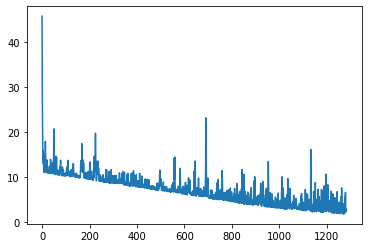

In [134]:
plt.plot([i for i in range(len(ls))], ls)

In [135]:
print("mnk:     \t", smape(squeeze_column(test_y), squeeze_column(test_F @ w_mnk)))
print("grad_mse:\t", smape(squeeze_column(test_y), squeeze_column(test_F @ w_grad_mse)))
print("grad_smape:\t", smape(squeeze_column(test_y), squeeze_column(test_F @ w_grad_smape)))

mnk:     	 0.0001837150592497553
grad_mse:	 0.7635203791488108
grad_smape:	 2.9103485992025666


In [148]:
print("mnk:     \t", nrmse(squeeze_column(test_y), squeeze_column(test_F @ w_mnk)))
print("grad_mse:\t", nrmse(squeeze_column(test_y), squeeze_column(test_F @ w_grad_mse)))
print("grad_smape:\t", nrmse(squeeze_column(test_y), squeeze_column(test_F @ w_grad_smape)))

mnk:     	 2.9299339040494166e-06
grad_mse:	 0.011908918787825287
grad_smape:	 0.04451597406317719
